In [1]:
# assume that firefox is installed via apt-get
# apt-get update
# apt-get install firefox

In [6]:
!pip install -U selenium
!pip install -U webdriver-manager
!pip install -U pandas
!pip install -U sqlalchemy
# !pip install -U 

  Using cached pandas-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 28.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.5 MB/s eta 0:00:005 MB/s eta 0:00:0101
  Using cached greenlet-2.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (539 kB)


In [7]:
# selenium 4
from selenium import webdriver
from selenium.webdriver.firefox.service import Service as FirefoxService
from webdriver_manager.firefox import GeckoDriverManager

driver = webdriver.Firefox(service=FirefoxService(GeckoDriverManager().install()))

driver.get("http://selenium.dev")

[WDM] - Downloading: 19.0kB [00:00, 12.3MB/s]                                   


In [4]:
!which firefox
!/usr/bin/firefox --version

/usr/bin/firefox
Mozilla Firefox 108.0


In [5]:
# from selenium import webdriver

# driver = webdriver.Firefox()
driver.get("http://selenium.dev")
driver.quit()

In [9]:
import pandas as pd
import requests
import sqlite3
import sqlalchemy as db
# import altair as alt
import datetime
from hashlib import sha224
from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options
from IPython.display import display, Image

# dashboard url to scrape
ud_covid_dashboard_url = 'https://udayton.edu/coronavirus/case_dashboard.php'

# create the sqlalchemy engine for the local database ... 
# table, `scrapes` is created like this:
# CREATE TABLE "scrapes" (
# 	"id"	INTEGER,
# 	"sha224_hash"	TEXT UNIQUE,
# 	"timestamp"	TEXT,
# 	"html_page"	BLOB,
# 	"html_page_screenshot"	BLOB,
# 	PRIMARY KEY("id" AUTOINCREMENT)
# )
engine = db.create_engine('sqlite:///data.db')

# display(Image('./CHPL_Brandmark_full_color_200.png'))

In [14]:
# Step 1:
# get the contents of the page
# produce a timestamp
# generate a hash digest of the page contents
# take a screenshot of the page (from a headless firefox browser)
# insert (or ignore if the hash is not unique) this data into an sqlite database

insert_sql = '''
INSERT OR IGNORE INTO scrapes
(sha224_hash, timestamp, html_page, html_page_screenshot) 

VALUES
(?, ?, ?, ?)
'''

# get the contents of the page
html_page = requests.get(ud_covid_dashboard_url)

# produce a timestamp
timestamp = datetime.datetime.now(
    tz=datetime.timezone.utc
).isoformat()

# generate a hash digest of the page contents
sha224_hash = sha224(
    html_page.text.encode(
        'utf-8'
    )
).hexdigest()

# take a screenshot of the page (from a headless firefox browser)
options = Options()
options.add_argument('-headless')
with Firefox(executable_path='./geckodriver',
             firefox_binary="/usr/bin/firefox",
             options=options) as driver:
    driver.get(ud_covid_dashboard_url)
    body = driver.find_element_by_tag_name('body')
    screenshot = body.screenshot_as_png
    
# insert (or ignore if the hash is not unique) this data into an sqlite database
with engine.connect() as connection:
    with connection.begin():
        insert_values = (sha224_hash,
                         timestamp,
                         html_page.text.encode('utf-8'),
                         screenshot,
                        )
        connection.execute(insert_sql, insert_values)

print('done!')

/tmp/ipykernel_25746/269759363.py:34: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  with Firefox(executable_path='./geckodriver',
/tmp/ipykernel_25746/269759363.py:34: DeprecationWarning: firefox_binary has been deprecated, please pass in a Service object
  with Firefox(executable_path='./geckodriver',


WebDriverException: Message: Service ./geckodriver unexpectedly exited. Status code was: 64


In [6]:
%%time
# get the last snapshot .. display the image from the db
sql = '''
SELECT
datetime(timestamp, 'localtime') as timestamp,
sha224_hash,
html_page,
html_page_screenshot

FROM
scrapes

ORDER BY
timestamp DESC

LIMIT 1
'''

with engine.connect() as connection:
    result = connection.execute(sql)
    for row in result:
        timestamp = row['timestamp']
        print('timestamp               : {}'.format(
            timestamp
        ))
        
        print('sha224_hash - db stored : {} '.format(
            row['sha224_hash']
        ))
        
        # as a sanity check, re-hash the page and get the hash digest to compare         
        print('sha224_hash - computed  : {}'.format(
            sha224(row['html_page']).hexdigest()
        ), end='\n---\n')
        
        # read the relevant part of the table into a dataframe
        df = pd.read_html(row['html_page'],
                          skiprows=2,
                          header=1,
                          flavor='bs4')[0]

        
# Plot data from the table / dataframe
# set the 'Date notified' to a usable date format
df['Date notified'] = pd.to_datetime(df['Date notified'], infer_datetime_format=True)

alt.Chart(df).mark_line().encode(
    x='Date notified:T',
    y='count(Date notified):Q',
    color='Position'
).properties(
    title='Counts of Reports by Date ({} Scrape)'.format(timestamp),
    width=600
)

timestamp               : 2020-08-28 13:31:30
sha224_hash - db stored : 2b77fd0eb2fb83b70f1fbcbda036d4eb11bf65fc2a623db95fefc84b 
sha224_hash - computed  : 2b77fd0eb2fb83b70f1fbcbda036d4eb11bf65fc2a623db95fefc84b
---
CPU times: user 224 ms, sys: 8.46 ms, total: 232 ms
Wall time: 232 ms


alt.Chart(...)

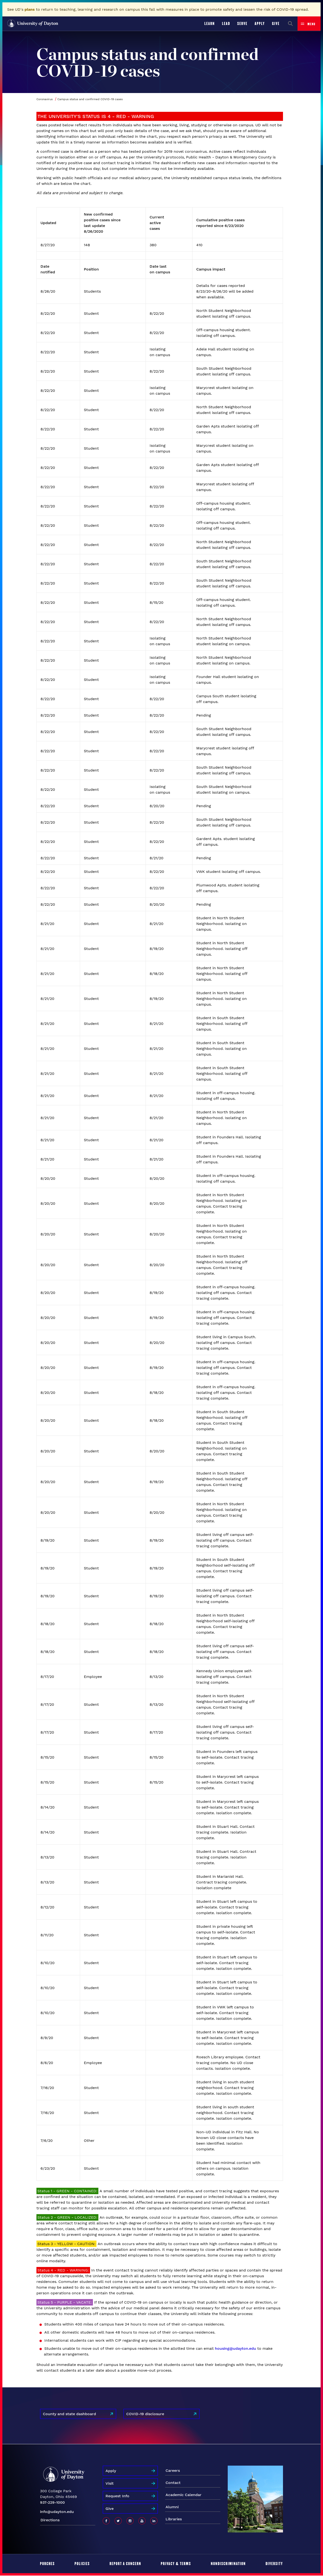

In [7]:
# display the source html_page_screenshot         
display(Image(row['html_page_screenshot']), )

In [9]:
# create a copy of the df
source = df.copy()


# source['Campus impact'] = None

In [8]:
source['isolating'] = source['Campus impact']

,Date notified,Position,Date last on campus,Campus impact
0,2020-08-25,Students,NaN,Details for cases reported 8/23/20-8/25/20 wil...
1,2020-08-22,Student,8/22/20,North Student Neighborhood student isolating o...
2,2020-08-22,Student,8/22/20,Off-campus housing student. Isolating off campus.
3,2020-08-22,Student,Isolating on campus,Adele Hall student Isolating on campus.
4,2020-08-22,Student,8/22/20,South Student Neighborhood student isolating o...
...,...,...,...,...
78,2020-08-06,Employee,NaN,Roesch Library employee. Contact tracing compl...
79,2020-07-16,Student,NaN,Student living in south student neighborhood. ...
80,2020-07-16,Student,NaN,Student living in south student neighborhood. ...
81,2020-07-06,Other,NaN,Non-UD individual in Fitz Hall. No known UD cl...
